# Land Cover Classification using Deep Learning Techniques and EuroSAT

### Testing for CS294-82 Project
### AJ Kumar

## Mounting google drive for dataset access and saving models

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [2]:
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn import model_selection

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
import tensorflow as tf
import tensorflow_datasets as tfds

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ./eurosat/rgb/2.0.0.incompleteUJ5J6F/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to ./eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


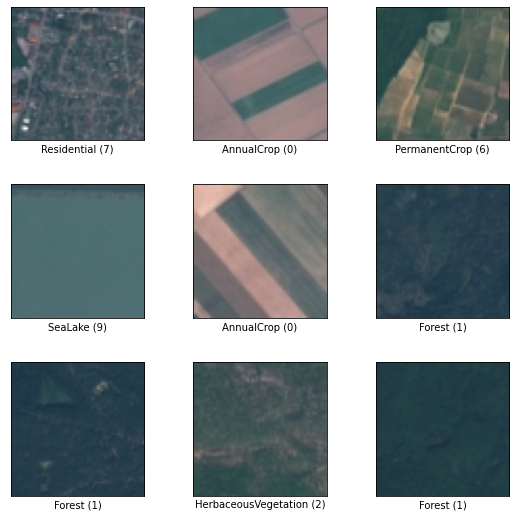

In [3]:
DATA_DIR = '.'

ds, ds_info = tfds.load('eurosat/rgb',
                        with_info=True,
                        split='train',
                        data_dir=DATA_DIR)

tfds.show_examples(ds, ds_info);

In [4]:
ds_df = tfds.as_dataframe(ds, ds_info)

In [5]:

ds_df.head()

filename  ... label
0    b'Residential_397.jpg'  ...     7
1     b'AnnualCrop_825.jpg'  ...     0
2  b'PermanentCrop_818.jpg'  ...     6
3         b'SeaLake_53.jpg'  ...     9
4     b'AnnualCrop_387.jpg'  ...     0

[5 rows x 3 columns]

## Config

In [6]:
# ROOT_PATH = '.'
# BASE_PATH = os.path.join(ROOT_PATH, 'Image_Dataset')
# DATA_PATH = os.path.join(ROOT_PATH, 'Dataset')
# FULL_DATA_DF = os.path.join(ROOT_PATH, 'FULL_DATA.csv')

# if not os.path.isdir(DATA_PATH):
#     os.mkdir(DATA_PATH)

IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest', 
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
  CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(10)
VALID_SIZE = 0.1


## Utils

In [7]:
## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

## Show batches of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [8]:

## Example for decoding and encoding
print(encode_label('Forest'), decode_target(2))
print(decode_target(2, text_labels=True))

1 HerbaceousVegetation
HerbaceousVegetation


## Pre-Processing data folders to train and test
Run this code cells only if you don't have the required dataframe

In [ ]:
# from os import walk
# i = 0
# for (dirpath, dirname, filename) in walk(BASE_PATH):
#   print("Directory Path: ", dirpath)
#   print("Directory Name: ", dirname)
#   print("Filename : ", filename)
#   print("----------------------"*10)
#   i += 1
#   if i > 3:
#     break

In [ ]:
# from os import walk

# i = 0
# DATA_DF = pd.DataFrame(columns = ['image_id', 'label']) 

# for (dirpath, dirname, filename) in walk(BASE_PATH):
#   for each_file in filename:
#     DATA_DF.loc[i] = [each_file, dirpath.split('/')[-1]]
#     i += 1
#   # break
# DATA_DF.to_csv(FULL_DATA_DF, index=False)
# DATA_DF.head()


## Processing data folders to train and test


In [8]:
DATA_DF = ds_df
DATA_DF['filename'].str.decode("utf-8")

0                  Residential_397.jpg
1                   AnnualCrop_825.jpg
2                PermanentCrop_818.jpg
3                       SeaLake_53.jpg
4                   AnnualCrop_387.jpg
                     ...              
26995            PermanentCrop_903.jpg
26996                   River_1297.jpg
26997                   Forest_950.jpg
26998                  Forest_2654.jpg
26999    HerbaceousVegetation_2624.jpg
Name: filename, Length: 27000, dtype: object

In [32]:
DATA_DF = DATA_DF.sample(frac = 1, random_state=48) 
TRAIN_DF = DATA_DF[:-int(len(DATA_DF)*VALID_SIZE*2)]
VALID_DF = DATA_DF[-int(len(DATA_DF)*VALID_SIZE*2) :-int(len(DATA_DF)*VALID_SIZE) ]
TEST_DF = DATA_DF[-int(len(DATA_DF)*VALID_SIZE): ]

In [33]:
TRAIN_DF.reset_index(inplace = True) 
TRAIN_DF.head()

index  ... label
0   5459  ...     8
1  12615  ...     3
2  14977  ...     5
3  17082  ...     3
4    914  ...     4

[5 rows x 4 columns]

In [34]:
VALID_DF.reset_index(inplace = True) 
VALID_DF.head()

index  ... label
0  26649  ...     9
1  15928  ...     8
2  19557  ...     5
3  11129  ...     2
4    270  ...     4

[5 rows x 4 columns]

In [35]:
TEST_DF.reset_index(inplace = True) 
TEST_DF.head()

index  ... label
0   7211  ...     1
1  12983  ...     6
2  17174  ...     9
3  21896  ...     3
4   3566  ...     5

[5 rows x 4 columns]

In [36]:
TRAIN_DF.shape, VALID_DF.shape, TEST_DF.shape

((21600, 4), (2700, 4), (2700, 4))

## Estimating noise in data

In [ ]:
from skimage.restoration import estimate_sigma

TRAIN_DF['noise'] = TRAIN_DF['image'].apply(lambda x: estimate_sigma(x, multichannel=True, average_sigmas=True))
TRAIN_DF['label_name'] = TRAIN_DF['label'].apply(lambda x: decode_target(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
mean_noise_by_class = TRAIN_DF.groupby('label_name', as_index=False)['noise'].mean()
mean_noise_by_class

label_name     noise
0            AnnualCrop  1.283801
1                Forest  1.248601
2  HerbaceousVegetation  2.099269
3               Highway  2.153391
4            Industrial  4.349241
5               Pasture  1.233249
6         PermanentCrop  2.296984
7           Residential  4.760420
8                 River  1.482672
9               SeaLake  0.811043

In [ ]:
std_noise_by_class = TRAIN_DF.groupby('label_name', as_index=False)['noise'].std()
std_noise_by_class

label_name     noise
0            AnnualCrop  0.320898
1                Forest  0.229878
2  HerbaceousVegetation  1.002573
3               Highway  0.922549
4            Industrial  1.266588
5               Pasture  0.192470
6         PermanentCrop  0.890631
7           Residential  1.725975
8                 River  0.430589
9               SeaLake  0.072133

In [ ]:
mean_noise_by_class['var_mean_ratio'] = std_noise_by_class['noise'] / mean_noise_by_class['noise']
mean_noise_by_class['snr'] = mean_noise_by_class['var_mean_ratio'].apply(lambda x: 20 * math.log10(x))
mean_noise_by_class

label_name     noise  var_mean_ratio        snr
0            AnnualCrop  1.283801        0.249959 -12.042613
1                Forest  1.248601        0.184108 -14.698539
2  HerbaceousVegetation  2.099269        0.477582  -6.419042
3               Highway  2.153391        0.428417  -7.362669
4            Industrial  4.349241        0.291220 -10.715565
5               Pasture  1.233249        0.156068 -16.133730
6         PermanentCrop  2.296984        0.387739  -8.229199
7           Residential  4.760420        0.362568  -8.812216
8                 River  1.482672        0.290414 -10.739654
9               SeaLake  0.811043        0.088938 -21.018222

In [ ]:
mean_noise_by_class[["label_name", "snr"]].sort_values(by=['snr']).rename(columns={"label_name": 'Class', 'snr': 'Noise resilience (dB)'})

Class  Noise resilience (dB)
9               SeaLake             -21.018222
5               Pasture             -16.133730
1                Forest             -14.698539
0            AnnualCrop             -12.042613
8                 River             -10.739654
4            Industrial             -10.715565
7           Residential              -8.812216
6         PermanentCrop              -8.229199
3               Highway              -7.362669
2  HerbaceousVegetation              -6.419042

## Creating Dataset and Dataloaders

Now we will Create custom dataset by extending pytorch Dataset class. We also add provision for adding transformers for data augmentation.

In [37]:
import torchvision.transforms as transforms

class EuroSAT(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['filename'], decode_target(row['label'])
        img = transforms.ToPILImage()(row['image'])
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

### Transformations and Datasets

In [38]:
## Dataset and transformations
data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
train_ds = EuroSAT(TRAIN_DF, '.', data_transform)
valid_ds = EuroSAT(VALID_DF, '.', data_transform)
test_ds = EuroSAT(TEST_DF, '.', data_transform)
print(len(train_ds), len(valid_ds), len(test_ds))

21600 2700 2700


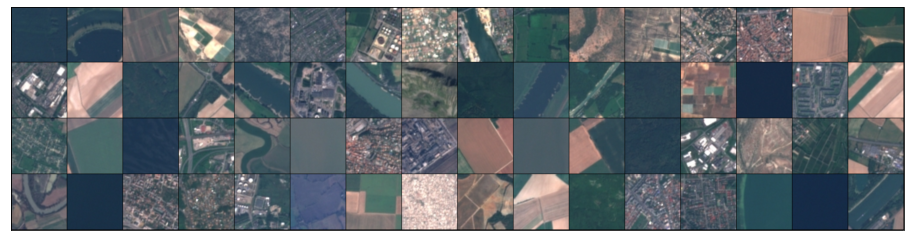

In [46]:
## Data loaders and showing batch of data
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True) 
show_batch(train_dl)

## Model

In [47]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [48]:
class LULC_Model(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = models.wide_resnet50_2(pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [ ]:
class GoogleNet(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [42]:
model = LULC_Model()


In [49]:
## Running through the data loader => Model => Output
def try_batch(dl):
  for images, labels in dl:  
    print(images.shape)
    out = model(images)
    print(out.shape)
    print(out[0])
    break

# try_batch(train_dl)

## Training and Evaluating

In [50]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):
  
    history = []
    valid_loss_min = np.Inf
    valid_acc_max = 0
    model_file_name = 'lulc.pth'
    model_file_name2 = 'lulc_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.00001)
                         
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):
            
            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
            
            
        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############                                         
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history                                
                                                 
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

## Initializing Device also Loading Data and Model to device¶


In [45]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [54]:

device = get_device()
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
## Loading model to device
model = to_device(model, device)
## lets try passing a batch to model again
try_batch(train_dl)

True
torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.2086, -2.1646, -2.3156, -2.2943, -2.2563, -2.3317, -2.3172, -2.3496,
        -2.3001, -2.5291], device='cuda:0', grad_fn=<SelectBackward0>)


In [52]:
torch.cuda.empty_cache()

## Training

In [55]:
## Hyper Parameters
max_epochs_stop = 200
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 12
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model, test_dl)

{'val_acc': 0.05741279199719429, 'val_loss': 2.3203487396240234}

In [ ]:
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.9176, learning_rate: 0.0001, train_loss: 0.2995, val_loss: 0.0996, val_acc: 0.9691


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9673, learning_rate: 0.0001, train_loss: 0.1106, val_loss: 0.1248, val_acc: 0.9575


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9724, learning_rate: 0.0001, train_loss: 0.0919, val_loss: 0.1001, val_acc: 0.9698


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9740, learning_rate: 0.0001, train_loss: 0.0848, val_loss: 0.2612, val_acc: 0.9208


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9833, learning_rate: 0.0000, train_loss: 0.0578, val_loss: 0.0866, val_acc: 0.9706


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9837, learning_rate: 0.0000, train_loss: 0.0568, val_loss: 0.0819, val_acc: 0.9724


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9840, learning_rate: 0.0000, train_loss: 0.0550, val_loss: 0.0809, val_acc: 0.9727


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9834, learning_rate: 0.0000, train_loss: 0.0594, val_loss: 0.0835, val_acc: 0.9713


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9830, learning_rate: 0.0000, train_loss: 0.0597, val_loss: 0.0786, val_acc: 0.9738


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9830, learning_rate: 0.0000, train_loss: 0.0594, val_loss: 0.0854, val_acc: 0.9713


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9824, learning_rate: 0.0000, train_loss: 0.0589, val_loss: 0.0808, val_acc: 0.9724


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9835, learning_rate: 0.0000, train_loss: 0.0564, val_loss: 0.0801, val_acc: 0.9731


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.9832, learning_rate: 0.0000, train_loss: 0.0582, val_loss: 0.0879, val_acc: 0.9695


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.9820, learning_rate: 0.0000, train_loss: 0.0598, val_loss: 0.0805, val_acc: 0.9724


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.9833, learning_rate: 0.0000, train_loss: 0.0560, val_loss: 0.0772, val_acc: 0.9735


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.9843, learning_rate: 0.0000, train_loss: 0.0567, val_loss: 0.0817, val_acc: 0.9724


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.9828, learning_rate: 0.0000, train_loss: 0.0586, val_loss: 0.0772, val_acc: 0.9738


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.9839, learning_rate: 0.0000, train_loss: 0.0571, val_loss: 0.0846, val_acc: 0.9713


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.9839, learning_rate: 0.0000, train_loss: 0.0541, val_loss: 0.0772, val_acc: 0.9742


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.9834, learning_rate: 0.0000, train_loss: 0.0567, val_loss: 0.0798, val_acc: 0.9731
VAL LOSS MIN 0.07715250551700592
VAL ACC MAX 0.9742006063461304


## Reports

### Training Reports

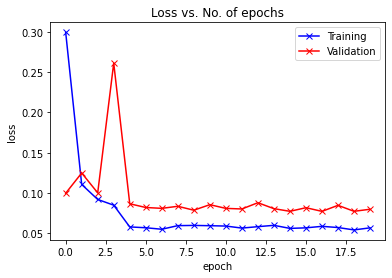

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

In [25]:
def plot_accuracy(history):
        
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
#plot_accuracy(history)

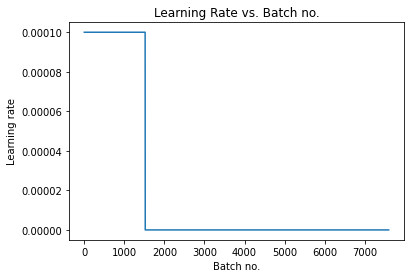

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

### Prediction Reports

In [ ]:
def show_sample(img, target=None):
    if target:
        print("Label" ,decode_target(int(target), text_labels=True))
    plt.imshow(img.permute(1, 2, 0))

### Predict Single Images
def predict_single(image):
    show_sample(image)
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    return decode_target(int(prediction), text_labels=True)


'Industrial'

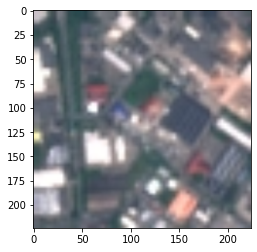

In [ ]:
predict_single(valid_ds[10][0])

'HerbaceousVegetation'

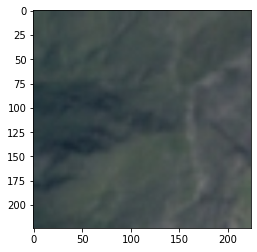

In [ ]:
predict_single(valid_ds[25][0])

'Residential'

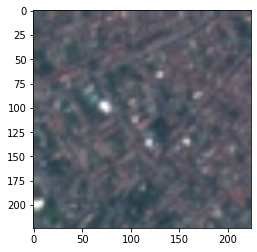

In [ ]:
predict_single(valid_ds[120][0])

## Evaluation on whole dataset and extract CNN layer per item

In [ ]:
batch_size = 1
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, labels = [], []
    for xb, label in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())     
        labels.append(label)   
    return [x for x in batch_pred], \
            [x for x in labels]

In [ ]:
# Save off CNN layer per image
# https://colab.research.google.com/github/kozodoi/website/blob/master/_notebooks/2021-05-27-extracting-features.ipynb

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

# Register hook
model.network.avgpool.register_forward_hook(get_features('avgpool'))

features = {}
batch_size = 1
@torch.no_grad()
def predict_extract_cnn_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, batch_cnns, labels = [], [], []

    for xb, label in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())    
        batch_cnns.append(features['avgpool'].cpu().numpy())
        labels.append(label.cpu().numpy())   
    return [x for x in batch_pred], [x for x in batch_cnns], [x for x in labels]

In [ ]:
## Accuracy Evaluation
def final_accuracy(predictions, labels):
  predictions = to_device(predictions, device)
  labels = to_device(labels, device)
  ## Total Accuracy
  total = 0
  for i in range(len(predictions)):
    if predictions[i] == labels[i]:
      total += 1
  acc = total/len(predictions)
  print(acc)

In [ ]:
full_ds = EuroSAT(DATA_DF, '.', data_transform)
full_dl = DataLoader(full_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
device = get_device()
## Loading data to devide
full_dl = DeviceDataLoader(full_dl, device)


True


In [ ]:
predictions, cnns, labels = predict_extract_cnn_dl(full_dl, model)

  0%|          | 0/27000 [00:00<?, ?it/s]

In [ ]:
cnns_flattened = [x.flatten() for x in cnns]
cnns_df = pd.DataFrame({'resnet_avgpool_layer': cnns_flattened, 'label': labels})

# cnns_df.to_csv('/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns.csv', index=False)
cnns_df.to_csv('/content/drive/MyDrive/CS294/data/rgb_resnet_cnns.csv', index=False)


TRAIN_CNNS_DF = cnns_df[:-int(len(cnns_df)*VALID_SIZE)]
VALID_CNNS_DF = cnns_df[-int(len(cnns_df)*VALID_SIZE) :]

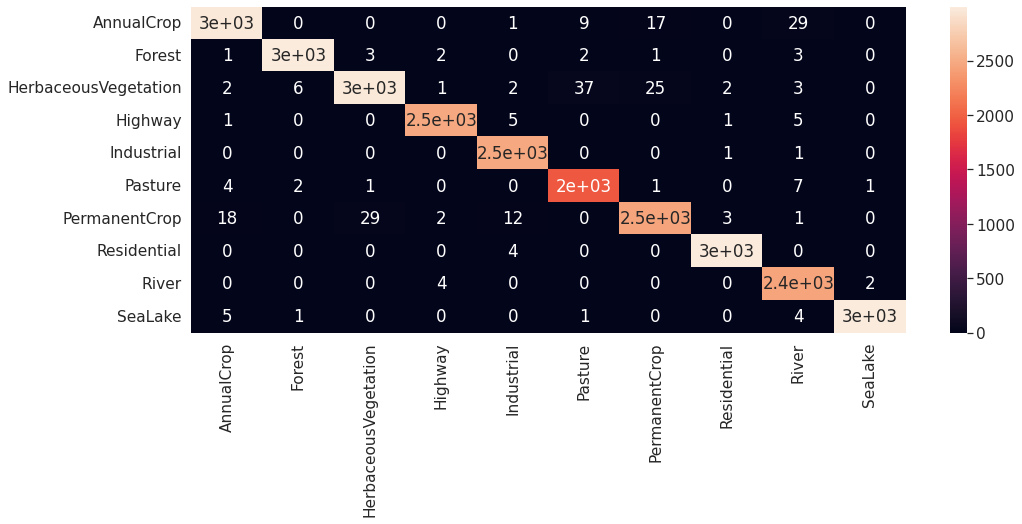

In [ ]:
## Plotting Confusion matrix
df_cm = pd.DataFrame(cm, CLASSES, CLASSES)
sns.set(font_scale=1.4) # for label size
plt.figure(figsize = (16,6))
sns.heatmap(df_cm, annot=True)

# Calculate data MEC

In [ ]:
def calculate_mec(data, labels):
	'''
	Calculate MEC needed for a classifier assuming weight
	equilibrium (no gradient descent). 
	Requires: data array of length n  which contains d-dim vectors 
	x, and a label column of length n.

	Parameters
    ----------
    data : array
    
    Returns
    -------
    mec : float

	'''
	assert len(data) == len(labels)
	d = data[0].shape[0]
	thresholds = 0
	table = []
	for i in range(len(data)):
	  # Sum up all data in the row and append the label
	  table.append([data[i].sum(), labels[i]])
	# Sort by sum in reverse order
	sortedtable = sorted(table, key=lambda x: x[0], reverse=True)

	# Iterate through sorted table and compute thresholds
	# by comparing class labels for each row and the prior row
	# Initialize with first class label in list
	class_label = sortedtable[0][1]
	for i in range(len(sortedtable)):
	  if not sortedtable[i][1] == class_label:
	    thresholds = thresholds + 1 
	    class_label = sortedtable[i][1]

	mec = math.log2(thresholds + 1) * d
	return mec

def get_sample(p, data, labels, seed):
	'''
	Return p percent of the data with corresponding labels.

	Parameters
	----------
	p : float in ragne [0, 1]
	data : array
	labels : array
    seed  : int

    Returns
    -------
    data, labels : array, array

	'''
	num_labels = len(labels)
	size = int(p * num_labels)

	np.random.seed(seed)
	np.random.shuffle(data)
	np.random.shuffle(labels)
	
	return data[:size], labels[:size] 


# Algorithm 2 
def calculate_capacity_progression(data, labels):
	'''
	Calculate capacity progression for the Equilibrium Machine Learner.
	Requires: data array of length n  which contains d-dim vectors 
	x, and a binary label column of length n.

	Parameters
    ----------
    data : array
    labels : array
    
    Returns
    -------
    capacities : dictionary

	'''
	sizes = [.05, .1, .2, .4, .8, 1]
	capacities = {}
	for size in sizes:
		sample_data, sample_labels = get_sample(size, data, labels, 1234)
		mec = calculate_mec(sample_data, sample_labels)
		capacities[size * 100] = mec
		
		print("MEC for " + str(int(size * 100)) + " percent of the data: " + str(round(mec, 2)) + " bits")

	return capacities	

In [ ]:
# Calculate MEC for training dataset
calculate_mec(TRAIN_CNNS_DF['resnet_avgpool_layer'], TRAIN_CNNS_DF['label'])

29283.312063083915

### Double checking data MEC using Brainome

In [ ]:
%pip install brainome

     |████████████████████████████████| 2.3 MB 4.3 MB/s 
     |████████████████████████████████| 133 kB 63.4 MB/s 
     |████████████████████████████████| 166.7 MB 21 kB/s 
     |████████████████████████████████| 15.7 MB 300 kB/s 
     |████████████████████████████████| 22.3 MB 5.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all th

In [ ]:
brainome_df = pd.DataFrame(cnns_flattened) 
brainome_df['label'] = labels
TRAIN_BRAINOME_DF = brainome_df[:-int(len(brainome_df)*VALID_SIZE)]
VALID_BRAINOME_DF = brainome_df[-int(len(brainome_df)*VALID_SIZE) :]
TRAIN_BRAINOME_DF.to_csv('/content/drive/MyDrive/CS294/data/rgb_resnet_cnns.csv', index=False)

In [ ]:
brainome_df.head()

0         1         2         3  ...      2045      2046      2047  label
0  0.963565  0.007149  0.002227  0.436075  ...  0.001490  0.113653  0.323734    [2]
1  0.079889  0.835666  0.147918  0.014640  ...  0.201103  0.101584  0.051432    [8]
2  1.383670  0.636990  0.015001  0.000934  ...  0.549764  0.172773  0.240737    [1]
3  0.044345  0.024932  0.062707  0.006103  ...  0.099038  0.058443  0.417927    [4]
4  0.025883  0.004518  0.000336  0.000000  ...  1.234979  0.220726  0.008052    [6]

[5 rows x 2049 columns]

In [ ]:
!brainome '/content/drive/MyDrive/CS294/data/rgb_resnet_cnns.csv' -v -y -target label -o rgb_10class_measurement_script.py


Brainome Table Compiler v1.700-108-prod
Copyright (c) 2019-2021 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2022-12-12   361 days left
Maximum File Size:           100 MB
Maximum Instances:           20000
Maximum Attributes:          100
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    btc /content/drive/MyDrive/CS294/data/rgb_resnet_cnns.csv -v -y -target label -o rgb_10class_measurement_script.py

Start Time:                 12/16/2021, 08:09 UTC

Cleaning...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\

# Capacity progression

In [ ]:
capacities = calculate_capacity_progression(TRAIN_CNNS_DF['resnet_avgpool_layer'], TRAIN_CNNS_DF['label'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MEC for 5 percent of the data: 20715.61 bits
MEC for 10 percent of the data: 22678.47 bits
MEC for 20 percent of the data: 24768.0 bits
MEC for 40 percent of the data: 26809.23 bits
MEC for 80 percent of the data: 28865.35 bits
MEC for 100 percent of the data: 29512.2 bits


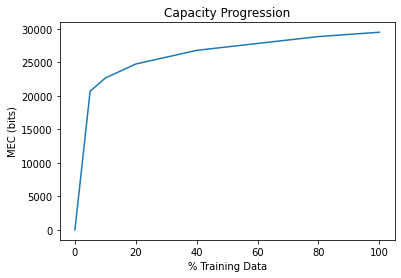

In [ ]:
capacities.update({0: 0})

lists = sorted(capacities.items()) # sorted by key, return a list of tuples

# Add title and axis names

plt.clf()
x, y = zip(*lists) # unpack a list of pairs into two tuples
# plt.ylim(0, 100)
plt.plot(x, y)
# plt.legend(loc='lower right')
plt.title('Capacity Progression')
plt.xlabel('% Training Data')
plt.ylabel('MEC (bits)')
plt.show()

# Network MEC

In [ ]:
network_mec = 2048 * 256 + 256 + min(256, (256 + 1) * 10)
network_mec
# Add 1 for bias at every level

524800

In [ ]:
model.network.fc = nn.Sequential(
                              nn.Linear(1024, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, 10),
                              nn.LogSoftmax(dim=1)
                                )
model

Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)

# Compute Generalization

In [ ]:
# final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

array([[2969,    0,    0,    0,    1,    9,   17,    0,   29,    0],
       [   1, 2991,    3,    2,    0,    2,    1,    0,    3,    0],
       [   2,    6, 2967,    1,    2,   37,   25,    2,    3,    0],
       [   1,    0,    0, 2491,    5,    0,    0,    1,    5,    0],
       [   0,    0,    0,    0, 2476,    0,    0,    1,    1,    0],
       [   4,    2,    1,    0,    0, 1951,    1,    0,    7,    1],
       [  18,    0,   29,    2,   12,    0, 2456,    3,    1,    0],
       [   0,    0,    0,    0,    4,    0,    0, 2993,    0,    0],
       [   0,    0,    0,    4,    0,    0,    0,    0, 2447,    2],
       [   5,    1,    0,    0,    0,    1,    0,    0,    4, 2997]])

In [ ]:
G = round((
    .1111 * math.log2(1/.1111) * 2969 + \
    .1111 * math.log2(1/.1111) * 2991 + \
    .1111 * math.log2(1/.1111) * 2967 + \
    .0926 * math.log2(1/.0926) * 2491 + \
    .0926 * math.log2(1/.0926) * 2476 + \
    .0741 * math.log2(1/.0741) * 1951 + \
    .0926 * math.log2(1/.0926) * 2456 + \
    .1111 * math.log2(1/.1111) * 2993 + \
    .0926 * math.log2(1/.0926) * 2447 + \
    .1111 * math.log2(1/.1111) * 2997) / 524800, 3)
G

0.017

# Compute Resilience

In [ ]:
R = round(20 * math.log10(G), 2)
R

-35.39

# Train for Generalization

In [ ]:
# Remove a layer
model.network.fc = nn.Sequential(
                              nn.Linear(1024, 10),
                              nn.LogSoftmax(dim=1)
                                )
model.network.fc

NameError: ignored

In [ ]:
model

GoogleNet(
  (network): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn):

In [ ]:
network_mec = 1024 * (10) + (10)
network_mec
# Add 1 for bias at every level

10250

In [ ]:
class capacity_estimator():
    
    def __init__(self):
        pass
    
    def estimate(self, num_inputs, neurons):
        """
        Estimates the Memory-Equivalent Capacity (MEC) *in bits* of a fully-connected neural network by practically sizing it 
        using the methods presented by Gerald Friedland, Mario Michael Krell & Alfredo Metere in 'A Practical Approach 
        to Sizing Neural Networks' in Lawrence Livermore National Laboratory publication LLNL-TR-758456.

        Arguments:
        > num_inputs: Number of inputs.
        > neurons: Numbers of neurons in the following fully connected layers.

        The four rules to capacity estimation are the following:
        1. The output of a perceptron is maximally 1 bit.
        2. The maximum memory capacity of a perceptron is the number of parameters in bits (MacKay '03).
        3. The maximum memory capacity of perceptrons in parallel is additive (MacKay '03 and Friedland '17).
        4. The maximum memory capacity of a layer of perceptrons depending on a previous layer of perceptrons is limited by
           the maximum output in bits of the previous layer (Data Processing Inequality, Tishby '12).
        """
        assert(len(neurons) >= 1, 'There has to be atleast 1 neuron')
        capacity = []

        first_layer_capacity = (num_inputs + 1) * neurons[0]
        print(first_layer_capacity)
        capacity.append(first_layer_capacity)
        for i in range(1, len(neurons)):
            layer_capacity = (neurons[i-1] + 1) * neurons[i]
            # print(neurons[i-1])
            # print(neurons[i])
            # print(layer_capacity)
            layer_capacity = min(neurons[i-1], layer_capacity)
            print(layer_capacity)
            capacity.append(layer_capacity)
        return sum(capacity)

ce = capacity_estimator()
ce.estimate(1024, [256, 10])
# source: https://github.com/Murthy1999/CS294-082

262400
256


<ipython-input-5-157f2920db5d>:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(neurons) >= 1, 'There has to be atleast 1 neuron')


262656

In [ ]:
# We use the following 4 rules to estimate the MEC of neural networks:
# 1.  The output of a perceptron is maximally 1 bit.
# 2. The maximum memory capacity of a perceptron is the number of parameters in bits (MacKay '03).
# 3. The maximum memory capacity of perceptrons in parallel is additive (MacKay '03 and Friedland '17).
# 4. The maximum memory capacity of a layer of perceptrons depending on a previous layer of perceptrons is limited by the maximum output in bits of the previous layer (Data Processing Inequality, Tishby '12).

In [ ]:
## Hyper Parameters
max_epochs_stop = 20
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 20
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model.cuda(), valid_dl)

{'val_acc': 0.039244186133146286, 'val_loss': 2.386420249938965}

In [ ]:
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.9810, learning_rate: 0.0001, train_loss: 0.1267, val_loss: 0.0769, val_acc: 0.9771


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9911, learning_rate: 0.0001, train_loss: 0.0353, val_loss: 0.0730, val_acc: 0.9778


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9930, learning_rate: 0.0001, train_loss: 0.0269, val_loss: 0.0705, val_acc: 0.9818


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9934, learning_rate: 0.0001, train_loss: 0.0265, val_loss: 0.0742, val_acc: 0.9786


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9924, learning_rate: 0.0001, train_loss: 0.0280, val_loss: 0.0643, val_acc: 0.9778


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9915, learning_rate: 0.0001, train_loss: 0.0295, val_loss: 0.0800, val_acc: 0.9753


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9940, learning_rate: 0.0001, train_loss: 0.0221, val_loss: 0.0583, val_acc: 0.9811


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9931, learning_rate: 0.0001, train_loss: 0.0249, val_loss: 0.0813, val_acc: 0.9775


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9955, learning_rate: 0.0001, train_loss: 0.0186, val_loss: 0.0664, val_acc: 0.9822


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9938, learning_rate: 0.0001, train_loss: 0.0239, val_loss: 0.1189, val_acc: 0.9654


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9944, learning_rate: 0.0000, train_loss: 0.0227, val_loss: 0.0691, val_acc: 0.9782


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9944, learning_rate: 0.0000, train_loss: 0.0220, val_loss: 0.0727, val_acc: 0.9764


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.9947, learning_rate: 0.0000, train_loss: 0.0222, val_loss: 0.0753, val_acc: 0.9764


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.9946, learning_rate: 0.0000, train_loss: 0.0224, val_loss: 0.0671, val_acc: 0.9786


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.9952, learning_rate: 0.0000, train_loss: 0.0218, val_loss: 0.0734, val_acc: 0.9771


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.9936, learning_rate: 0.0000, train_loss: 0.0249, val_loss: 0.0713, val_acc: 0.9793


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.9947, learning_rate: 0.0000, train_loss: 0.0215, val_loss: 0.0654, val_acc: 0.9804


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.9949, learning_rate: 0.0000, train_loss: 0.0211, val_loss: 0.0684, val_acc: 0.9782


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.9941, learning_rate: 0.0000, train_loss: 0.0228, val_loss: 0.0677, val_acc: 0.9793


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.9940, learning_rate: 0.0000, train_loss: 0.0230, val_loss: 0.0710, val_acc: 0.9782
VAL LOSS MIN 0.058303575962781906
VAL ACC MAX 0.9821947813034058


In [ ]:
# train_accu: 0.9896, learning_rate: 0.0000, train_loss: 0.0352, val_loss: 0.0831, val_acc: 0.9746

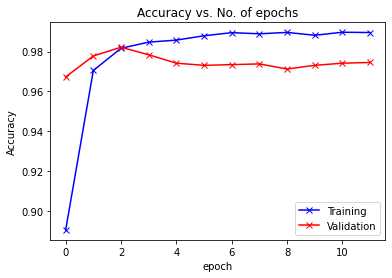

In [ ]:
def plot_accuracy(history):
        
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracy(history)

# Testing a Shallow CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(MulticlassClassifierBase):

    def __init__(self):
        super(Net, self).__init__()

        # 1 input image channel, 12 output channels, 5x5 square convolution
        # kernel
        
        conv1_in_channels=3
        conv1_out_channels=12

        conv2_in_channels=conv1_out_channels
        conv2_out_channels=24

        conv3_in_channels=conv2_out_channels
        conv3_out_channels=3

        # conv4_in_channels=conv3_out_channels
        # conv4_out_channels=32

        padding=0

        # fc_in = c * h * w
        fc1_in_features=conv3_out_channels * 17 * 17  # from image dimension at conv1 output
        fc1_out_features=10

        # fc2_in_features=fc1_out_features
        # fc2_out_features=10 # Final # classes = 2 for x, y coords

        self.conv1 = nn.Conv2d(in_channels=conv1_in_channels, out_channels=conv1_out_channels, kernel_size=13, padding=padding)
        self.conv2 = nn.Conv2d(in_channels=conv2_in_channels, out_channels=conv2_out_channels, kernel_size=13, padding=padding)
        self.conv3 = nn.Conv2d(in_channels=conv3_in_channels, out_channels=conv3_out_channels, kernel_size=13, padding=padding)
        # self.conv4 = nn.Conv2d(in_channels=conv4_in_channels, out_channels=conv4_out_channels, kernel_size=3, padding=padding)
        self.fc1 = nn.Linear(in_features=fc1_in_features, out_features=fc1_out_features) 
        # self.fc2 = nn.Linear(in_features=fc2_in_features, out_features=fc2_out_features) 

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # print(x.shape)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        # print(x.shape)
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        # print(x.shape)
        # x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        # print(x.shape)
        x = nn.LogSoftmax(dim=1)((self.fc1(x)))
        # print(x.shape)
        # x = self.fc2(x)
        # print(x.shape)
        return x

model = Net()
print(model)

# # Remove a layer
# model.network.fc = nn.Sequential(
#                               nn.Linear(1024, 10),
#                               nn.LogSoftmax(dim=1)
#                                 )

Net(
  (conv1): Conv2d(3, 12, kernel_size=(13, 13), stride=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(13, 13), stride=(1, 1))
  (conv3): Conv2d(24, 3, kernel_size=(13, 13), stride=(1, 1))
  (fc1): Linear(in_features=867, out_features=10, bias=True)
)


In [ ]:
# Test dummy input
input = torch.randn(1, 3, 224, 224)
print(input.shape)

out = model(input)
print(out)

torch.Size([1, 3, 224, 224])
tensor([[-2.4398, -2.1864, -2.3713, -2.2469, -2.2704, -2.4257, -2.6622, -2.1238,
         -2.1405, -2.2754]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
ce.estimate(800, [10])

8010

In [ ]:
## Hyper Parameters
max_epochs_stop = 200
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 20
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model.cuda(), valid_dl)

{'val_acc': 0.15855136513710022, 'val_loss': 2.304673671722412}

In [ ]:
## Freezing except last layer
# model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
## Freezing except last layer
# model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.5201, learning_rate: 0.0001, train_loss: 1.3768, val_loss: 1.1900, val_acc: 0.5677


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.5334, learning_rate: 0.0001, train_loss: 1.2791, val_loss: 1.3692, val_acc: 0.5489


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.5270, learning_rate: 0.0001, train_loss: 1.3194, val_loss: 1.1785, val_acc: 0.5632


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.5278, learning_rate: 0.0001, train_loss: 1.3170, val_loss: 1.2018, val_acc: 0.5661


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.5405, learning_rate: 0.0001, train_loss: 1.2717, val_loss: 1.1917, val_acc: 0.5747


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.5425, learning_rate: 0.0001, train_loss: 1.2650, val_loss: 1.1176, val_acc: 0.5998


  0%|          | 0/380 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c943b4cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c943b4cb0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch [6],train_accu: 0.5386, learning_rate: 0.0001, train_loss: 1.3258, val_loss: 1.3039, val_acc: 0.5425


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.5405, learning_rate: 0.0001, train_loss: 1.2875, val_loss: 1.3134, val_acc: 0.5264


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.5246, learning_rate: 0.0001, train_loss: 1.3830, val_loss: 1.2629, val_acc: 0.5418


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.5496, learning_rate: 0.0000, train_loss: 1.2555, val_loss: 1.2555, val_acc: 0.5436


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.5522, learning_rate: 0.0000, train_loss: 1.2476, val_loss: 1.2479, val_acc: 0.5451


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.5545, learning_rate: 0.0000, train_loss: 1.2403, val_loss: 1.2406, val_acc: 0.5480


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.5566, learning_rate: 0.0000, train_loss: 1.2331, val_loss: 1.2335, val_acc: 0.5498


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.5594, learning_rate: 0.0000, train_loss: 1.2261, val_loss: 1.2269, val_acc: 0.5516


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.5623, learning_rate: 0.0000, train_loss: 1.2196, val_loss: 1.2204, val_acc: 0.5509


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.5644, learning_rate: 0.0000, train_loss: 1.2135, val_loss: 1.2143, val_acc: 0.5527


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.5674, learning_rate: 0.0000, train_loss: 1.2072, val_loss: 1.2081, val_acc: 0.5538


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.5690, learning_rate: 0.0000, train_loss: 1.2011, val_loss: 1.2022, val_acc: 0.5570


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.5709, learning_rate: 0.0000, train_loss: 1.1953, val_loss: 1.1967, val_acc: 0.5596


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.5731, learning_rate: 0.0000, train_loss: 1.1900, val_loss: 1.1913, val_acc: 0.5625
VAL LOSS MIN 1.1176223754882812
VAL ACC MAX 0.5998062491416931


In [ ]:
## Freezing except last layer
# model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.5419, learning_rate: 0.0001, train_loss: 1.3138, val_loss: 1.1454, val_acc: 0.5998


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.5471, learning_rate: 0.0001, train_loss: 1.2842, val_loss: 1.1597, val_acc: 0.5819


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.5467, learning_rate: 0.0001, train_loss: 1.3211, val_loss: 1.1326, val_acc: 0.5798


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.5504, learning_rate: 0.0001, train_loss: 1.3270, val_loss: 1.1053, val_acc: 0.5987


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.5474, learning_rate: 0.0001, train_loss: 1.3280, val_loss: 1.1847, val_acc: 0.5724


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.5631, learning_rate: 0.0001, train_loss: 1.2416, val_loss: 1.1345, val_acc: 0.6011


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.5564, learning_rate: 0.0001, train_loss: 1.2875, val_loss: 1.0623, val_acc: 0.6148


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.5621, learning_rate: 0.0001, train_loss: 1.2427, val_loss: 1.2292, val_acc: 0.5620


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.5701, learning_rate: 0.0001, train_loss: 1.2260, val_loss: 1.0765, val_acc: 0.6168


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.5700, learning_rate: 0.0001, train_loss: 1.2313, val_loss: 1.1126, val_acc: 0.5992


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.6066, learning_rate: 0.0000, train_loss: 1.1075, val_loss: 1.1109, val_acc: 0.5992


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.6072, learning_rate: 0.0000, train_loss: 1.1057, val_loss: 1.1092, val_acc: 0.5992


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.6081, learning_rate: 0.0000, train_loss: 1.1040, val_loss: 1.1075, val_acc: 0.6007


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.6087, learning_rate: 0.0000, train_loss: 1.1027, val_loss: 1.1060, val_acc: 0.6007


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.6092, learning_rate: 0.0000, train_loss: 1.1012, val_loss: 1.1045, val_acc: 0.6010


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.6099, learning_rate: 0.0000, train_loss: 1.1002, val_loss: 1.1031, val_acc: 0.6036


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.6103, learning_rate: 0.0000, train_loss: 1.0986, val_loss: 1.1016, val_acc: 0.6047


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.6108, learning_rate: 0.0000, train_loss: 1.0973, val_loss: 1.1003, val_acc: 0.6061


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.6110, learning_rate: 0.0000, train_loss: 1.0964, val_loss: 1.0991, val_acc: 0.6079


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.6113, learning_rate: 0.0000, train_loss: 1.0953, val_loss: 1.0980, val_acc: 0.6090
VAL LOSS MIN 1.0622950792312622
VAL ACC MAX 0.6167635321617126


In [ ]:
## Freezing except last layer
# model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.5864, learning_rate: 0.0001, train_loss: 1.1820, val_loss: 1.3288, val_acc: 0.5344


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.5902, learning_rate: 0.0001, train_loss: 1.1613, val_loss: 1.0812, val_acc: 0.6174


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.5869, learning_rate: 0.0001, train_loss: 1.1824, val_loss: 1.1059, val_acc: 0.6157


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.6045, learning_rate: 0.0001, train_loss: 1.1280, val_loss: 1.2116, val_acc: 0.5844


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.6043, learning_rate: 0.0001, train_loss: 1.1334, val_loss: 1.1026, val_acc: 0.6014


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.6119, learning_rate: 0.0000, train_loss: 1.0780, val_loss: 1.0997, val_acc: 0.6017


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.6126, learning_rate: 0.0000, train_loss: 1.0752, val_loss: 1.0970, val_acc: 0.6032


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.6127, learning_rate: 0.0000, train_loss: 1.0730, val_loss: 1.0946, val_acc: 0.6039


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.6135, learning_rate: 0.0000, train_loss: 1.0712, val_loss: 1.0923, val_acc: 0.6054


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.6137, learning_rate: 0.0000, train_loss: 1.0690, val_loss: 1.0903, val_acc: 0.6061


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.6143, learning_rate: 0.0000, train_loss: 1.0673, val_loss: 1.0884, val_acc: 0.6065


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.6150, learning_rate: 0.0000, train_loss: 1.0654, val_loss: 1.0865, val_acc: 0.6057


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.6155, learning_rate: 0.0000, train_loss: 1.0637, val_loss: 1.0848, val_acc: 0.6065


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.6158, learning_rate: 0.0000, train_loss: 1.0624, val_loss: 1.0831, val_acc: 0.6072


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.6159, learning_rate: 0.0000, train_loss: 1.0612, val_loss: 1.0817, val_acc: 0.6076


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.6163, learning_rate: 0.0000, train_loss: 1.0599, val_loss: 1.0803, val_acc: 0.6086


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.6172, learning_rate: 0.0000, train_loss: 1.0585, val_loss: 1.0791, val_acc: 0.6097


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.6176, learning_rate: 0.0000, train_loss: 1.0573, val_loss: 1.0779, val_acc: 0.6094


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.6179, learning_rate: 0.0000, train_loss: 1.0566, val_loss: 1.0768, val_acc: 0.6105


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.6182, learning_rate: 0.0000, train_loss: 1.0553, val_loss: 1.0757, val_acc: 0.6112
VAL LOSS MIN 1.0756853818893433
VAL ACC MAX 0.6173691749572754


In [ ]:
## Freezing except last layer
# model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.5930, learning_rate: 0.0001, train_loss: 1.1877, val_loss: 1.1621, val_acc: 0.5913


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.6236, learning_rate: 0.0001, train_loss: 1.0745, val_loss: 1.0671, val_acc: 0.6251


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.6192, learning_rate: 0.0001, train_loss: 1.0924, val_loss: 1.1266, val_acc: 0.6163


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.6270, learning_rate: 0.0001, train_loss: 1.0683, val_loss: 1.0878, val_acc: 0.6257


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.6290, learning_rate: 0.0001, train_loss: 1.0647, val_loss: 1.1250, val_acc: 0.6045


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.6144, learning_rate: 0.0000, train_loss: 1.1045, val_loss: 1.1210, val_acc: 0.6060


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.6159, learning_rate: 0.0000, train_loss: 1.1007, val_loss: 1.1170, val_acc: 0.6071


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.6172, learning_rate: 0.0000, train_loss: 1.0972, val_loss: 1.1132, val_acc: 0.6078


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.6178, learning_rate: 0.0000, train_loss: 1.0938, val_loss: 1.1095, val_acc: 0.6096


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.6192, learning_rate: 0.0000, train_loss: 1.0904, val_loss: 1.1058, val_acc: 0.6100


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.6204, learning_rate: 0.0000, train_loss: 1.0867, val_loss: 1.1021, val_acc: 0.6114


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.6218, learning_rate: 0.0000, train_loss: 1.0835, val_loss: 1.0986, val_acc: 0.6125


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.6229, learning_rate: 0.0000, train_loss: 1.0805, val_loss: 1.0952, val_acc: 0.6136


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.6244, learning_rate: 0.0000, train_loss: 1.0774, val_loss: 1.0918, val_acc: 0.6140


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.6254, learning_rate: 0.0000, train_loss: 1.0741, val_loss: 1.0884, val_acc: 0.6158


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.6268, learning_rate: 0.0000, train_loss: 1.0711, val_loss: 1.0852, val_acc: 0.6176


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.6275, learning_rate: 0.0000, train_loss: 1.0684, val_loss: 1.0820, val_acc: 0.6194


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.6284, learning_rate: 0.0000, train_loss: 1.0653, val_loss: 1.0789, val_acc: 0.6228


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.6294, learning_rate: 0.0000, train_loss: 1.0627, val_loss: 1.0759, val_acc: 0.6243


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.6305, learning_rate: 0.0000, train_loss: 1.0599, val_loss: 1.0729, val_acc: 0.6254
VAL LOSS MIN 1.0670864582061768
VAL ACC MAX 0.6257267594337463


In [ ]:
## Freezing except last layer
# model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.6330, learning_rate: 0.0001, train_loss: 1.0649, val_loss: 1.0419, val_acc: 0.6420


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.6243, learning_rate: 0.0001, train_loss: 1.0951, val_loss: 1.0680, val_acc: 0.6326


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.6327, learning_rate: 0.0001, train_loss: 1.0648, val_loss: 1.0283, val_acc: 0.6470


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.6351, learning_rate: 0.0001, train_loss: 1.0572, val_loss: 1.1995, val_acc: 0.5807


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.6307, learning_rate: 0.0001, train_loss: 1.0635, val_loss: 1.1250, val_acc: 0.6216


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.6307, learning_rate: 0.0001, train_loss: 1.0663, val_loss: 1.0336, val_acc: 0.6360


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.6341, learning_rate: 0.0000, train_loss: 1.0203, val_loss: 1.0324, val_acc: 0.6364


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.6346, learning_rate: 0.0000, train_loss: 1.0188, val_loss: 1.0311, val_acc: 0.6364


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.6349, learning_rate: 0.0000, train_loss: 1.0179, val_loss: 1.0300, val_acc: 0.6364


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.6355, learning_rate: 0.0000, train_loss: 1.0165, val_loss: 1.0288, val_acc: 0.6386


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.6364, learning_rate: 0.0000, train_loss: 1.0153, val_loss: 1.0277, val_acc: 0.6393


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.6370, learning_rate: 0.0000, train_loss: 1.0143, val_loss: 1.0266, val_acc: 0.6397


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.6376, learning_rate: 0.0000, train_loss: 1.0131, val_loss: 1.0256, val_acc: 0.6404


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.6382, learning_rate: 0.0000, train_loss: 1.0122, val_loss: 1.0246, val_acc: 0.6415


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.6388, learning_rate: 0.0000, train_loss: 1.0114, val_loss: 1.0235, val_acc: 0.6399


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.6392, learning_rate: 0.0000, train_loss: 1.0100, val_loss: 1.0226, val_acc: 0.6395


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.6396, learning_rate: 0.0000, train_loss: 1.0092, val_loss: 1.0216, val_acc: 0.6410


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.6399, learning_rate: 0.0000, train_loss: 1.0082, val_loss: 1.0207, val_acc: 0.6417


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.6402, learning_rate: 0.0000, train_loss: 1.0074, val_loss: 1.0198, val_acc: 0.6435


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.6408, learning_rate: 0.0000, train_loss: 1.0063, val_loss: 1.0190, val_acc: 0.6435
VAL LOSS MIN 1.0189588069915771
VAL ACC MAX 0.6470445990562439


In [ ]:
## Freezing except last layer
# model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.6327, learning_rate: 0.0001, train_loss: 1.0585, val_loss: 1.0496, val_acc: 0.6275


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.6406, learning_rate: 0.0001, train_loss: 1.0405, val_loss: 1.0626, val_acc: 0.6467


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.6503, learning_rate: 0.0001, train_loss: 1.0136, val_loss: 1.0161, val_acc: 0.6670


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.6510, learning_rate: 0.0001, train_loss: 1.0022, val_loss: 1.0347, val_acc: 0.6394


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.6519, learning_rate: 0.0001, train_loss: 1.0113, val_loss: 1.1533, val_acc: 0.6168


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.6498, learning_rate: 0.0001, train_loss: 1.0151, val_loss: 1.0337, val_acc: 0.6509


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.6487, learning_rate: 0.0000, train_loss: 1.0121, val_loss: 1.0327, val_acc: 0.6506


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.6489, learning_rate: 0.0000, train_loss: 1.0111, val_loss: 1.0317, val_acc: 0.6506


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.6492, learning_rate: 0.0000, train_loss: 1.0101, val_loss: 1.0308, val_acc: 0.6506


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.6494, learning_rate: 0.0000, train_loss: 1.0091, val_loss: 1.0299, val_acc: 0.6502


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.6496, learning_rate: 0.0000, train_loss: 1.0083, val_loss: 1.0289, val_acc: 0.6498


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.6500, learning_rate: 0.0000, train_loss: 1.0075, val_loss: 1.0281, val_acc: 0.6502


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.6503, learning_rate: 0.0000, train_loss: 1.0065, val_loss: 1.0272, val_acc: 0.6498


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.6505, learning_rate: 0.0000, train_loss: 1.0056, val_loss: 1.0264, val_acc: 0.6495


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.6508, learning_rate: 0.0000, train_loss: 1.0049, val_loss: 1.0256, val_acc: 0.6502


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.6507, learning_rate: 0.0000, train_loss: 1.0039, val_loss: 1.0248, val_acc: 0.6498


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.6510, learning_rate: 0.0000, train_loss: 1.0031, val_loss: 1.0240, val_acc: 0.6509


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.6511, learning_rate: 0.0000, train_loss: 1.0024, val_loss: 1.0232, val_acc: 0.6509


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.6512, learning_rate: 0.0000, train_loss: 1.0017, val_loss: 1.0225, val_acc: 0.6509


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.6515, learning_rate: 0.0000, train_loss: 1.0009, val_loss: 1.0218, val_acc: 0.6506
VAL LOSS MIN 1.0161471366882324
VAL ACC MAX 0.6670300960540771


In [ ]:
## Freezing except last layer
# model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.6552, learning_rate: 0.0001, train_loss: 0.9994, val_loss: 0.9929, val_acc: 0.6633


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.6649, learning_rate: 0.0001, train_loss: 0.9663, val_loss: 1.0511, val_acc: 0.6417


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.6557, learning_rate: 0.0001, train_loss: 0.9886, val_loss: 0.9838, val_acc: 0.6658


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.6677, learning_rate: 0.0001, train_loss: 0.9524, val_loss: 0.9708, val_acc: 0.6489


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.6625, learning_rate: 0.0001, train_loss: 0.9618, val_loss: 0.9437, val_acc: 0.6674


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.6651, learning_rate: 0.0001, train_loss: 0.9569, val_loss: 1.0111, val_acc: 0.6506


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.6703, learning_rate: 0.0001, train_loss: 0.9486, val_loss: 1.0368, val_acc: 0.6553


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.6651, learning_rate: 0.0001, train_loss: 0.9578, val_loss: 0.9532, val_acc: 0.6744


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.6637, learning_rate: 0.0000, train_loss: 0.9348, val_loss: 0.9528, val_acc: 0.6751


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.6637, learning_rate: 0.0000, train_loss: 0.9345, val_loss: 0.9525, val_acc: 0.6755


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.6643, learning_rate: 0.0000, train_loss: 0.9339, val_loss: 0.9522, val_acc: 0.6755


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.6645, learning_rate: 0.0000, train_loss: 0.9336, val_loss: 0.9519, val_acc: 0.6759


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.6645, learning_rate: 0.0000, train_loss: 0.9333, val_loss: 0.9516, val_acc: 0.6759


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.6647, learning_rate: 0.0000, train_loss: 0.9327, val_loss: 0.9513, val_acc: 0.6766


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.6648, learning_rate: 0.0000, train_loss: 0.9324, val_loss: 0.9510, val_acc: 0.6766


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.6651, learning_rate: 0.0000, train_loss: 0.9319, val_loss: 0.9507, val_acc: 0.6759


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.6655, learning_rate: 0.0000, train_loss: 0.9316, val_loss: 0.9504, val_acc: 0.6759


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.6655, learning_rate: 0.0000, train_loss: 0.9318, val_loss: 0.9501, val_acc: 0.6766


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.6656, learning_rate: 0.0000, train_loss: 0.9311, val_loss: 0.9498, val_acc: 0.6770


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.6659, learning_rate: 0.0000, train_loss: 0.9305, val_loss: 0.9495, val_acc: 0.6777
VAL LOSS MIN 0.9436708688735962
VAL ACC MAX 0.6776889562606812


In [ ]:
## Freezing except last layer
# model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.6717, learning_rate: 0.0001, train_loss: 0.9356, val_loss: 0.9617, val_acc: 0.6727


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.6733, learning_rate: 0.0001, train_loss: 0.9279, val_loss: 0.9182, val_acc: 0.6928


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.6784, learning_rate: 0.0001, train_loss: 0.9151, val_loss: 0.9710, val_acc: 0.6638


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.6840, learning_rate: 0.0001, train_loss: 0.9097, val_loss: 1.0283, val_acc: 0.6532


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.6780, learning_rate: 0.0001, train_loss: 0.9168, val_loss: 0.9363, val_acc: 0.6777


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.6925, learning_rate: 0.0000, train_loss: 0.8860, val_loss: 0.9357, val_acc: 0.6784


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.6926, learning_rate: 0.0000, train_loss: 0.8854, val_loss: 0.9352, val_acc: 0.6784


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.6927, learning_rate: 0.0000, train_loss: 0.8849, val_loss: 0.9347, val_acc: 0.6781


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.6928, learning_rate: 0.0000, train_loss: 0.8847, val_loss: 0.9342, val_acc: 0.6781


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.6930, learning_rate: 0.0000, train_loss: 0.8841, val_loss: 0.9337, val_acc: 0.6784


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.6930, learning_rate: 0.0000, train_loss: 0.8837, val_loss: 0.9332, val_acc: 0.6784


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.6930, learning_rate: 0.0000, train_loss: 0.8835, val_loss: 0.9328, val_acc: 0.6781


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.6932, learning_rate: 0.0000, train_loss: 0.8831, val_loss: 0.9323, val_acc: 0.6781


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.6933, learning_rate: 0.0000, train_loss: 0.8827, val_loss: 0.9318, val_acc: 0.6784


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.6933, learning_rate: 0.0000, train_loss: 0.8823, val_loss: 0.9314, val_acc: 0.6791


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.6934, learning_rate: 0.0000, train_loss: 0.8820, val_loss: 0.9309, val_acc: 0.6802


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.6933, learning_rate: 0.0000, train_loss: 0.8817, val_loss: 0.9305, val_acc: 0.6806


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.6933, learning_rate: 0.0000, train_loss: 0.8816, val_loss: 0.9300, val_acc: 0.6810


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.6935, learning_rate: 0.0000, train_loss: 0.8813, val_loss: 0.9296, val_acc: 0.6806


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.6936, learning_rate: 0.0000, train_loss: 0.8810, val_loss: 0.9292, val_acc: 0.6806
VAL LOSS MIN 0.9182010293006897
VAL ACC MAX 0.6928294897079468


In [ ]:
torch.save(model, '/content/drive/MyDrive/CS29482/data/shallow_cnn_model.pth')

In [ ]:
## Freezing except last layer
# model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.6846, learning_rate: 0.0001, train_loss: 0.9050, val_loss: 0.9593, val_acc: 0.6751


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.6765, learning_rate: 0.0001, train_loss: 0.9209, val_loss: 0.9140, val_acc: 0.6850


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.6807, learning_rate: 0.0001, train_loss: 0.9041, val_loss: 0.9817, val_acc: 0.6584


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.6899, learning_rate: 0.0001, train_loss: 0.8751, val_loss: 0.8762, val_acc: 0.7000


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.6878, learning_rate: 0.0001, train_loss: 0.8774, val_loss: 0.9231, val_acc: 0.6909


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.6891, learning_rate: 0.0001, train_loss: 0.8830, val_loss: 0.8611, val_acc: 0.6914


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.6930, learning_rate: 0.0001, train_loss: 0.8720, val_loss: 0.8929, val_acc: 0.6999


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.6874, learning_rate: 0.0001, train_loss: 0.8744, val_loss: 0.8957, val_acc: 0.6896


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.6944, learning_rate: 0.0001, train_loss: 0.8672, val_loss: 0.8584, val_acc: 0.7167


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.6950, learning_rate: 0.0001, train_loss: 0.8604, val_loss: 0.9448, val_acc: 0.6762


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.6916, learning_rate: 0.0001, train_loss: 0.8590, val_loss: 0.8689, val_acc: 0.6992


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.6905, learning_rate: 0.0001, train_loss: 0.8678, val_loss: 0.8513, val_acc: 0.7066


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.6932, learning_rate: 0.0001, train_loss: 0.8639, val_loss: 0.9720, val_acc: 0.6604


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.6924, learning_rate: 0.0001, train_loss: 0.8712, val_loss: 0.8856, val_acc: 0.6971


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.6911, learning_rate: 0.0001, train_loss: 0.8727, val_loss: 1.0296, val_acc: 0.6202


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.6369, learning_rate: 0.0000, train_loss: 1.0056, val_loss: 1.0269, val_acc: 0.6212


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.6374, learning_rate: 0.0000, train_loss: 1.0026, val_loss: 1.0243, val_acc: 0.6220


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.6380, learning_rate: 0.0000, train_loss: 1.0004, val_loss: 1.0218, val_acc: 0.6227


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.6388, learning_rate: 0.0000, train_loss: 0.9977, val_loss: 1.0194, val_acc: 0.6234


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.6396, learning_rate: 0.0000, train_loss: 0.9954, val_loss: 1.0170, val_acc: 0.6256
VAL LOSS MIN 0.8513103127479553
VAL ACC MAX 0.7166908383369446


In [ ]:
torch.save(model, '/content/drive/MyDrive/CS29482/data/shallow_cnn_model.pth')

In [ ]:
## Freezing except last layer
# model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.6981, learning_rate: 0.0001, train_loss: 0.8619, val_loss: 0.9235, val_acc: 0.7006


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.6932, learning_rate: 0.0001, train_loss: 0.8697, val_loss: 0.9431, val_acc: 0.6692


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.6955, learning_rate: 0.0001, train_loss: 0.8637, val_loss: 0.9204, val_acc: 0.6728


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.6975, learning_rate: 0.0001, train_loss: 0.8698, val_loss: 0.8947, val_acc: 0.6788


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.6946, learning_rate: 0.0001, train_loss: 0.8698, val_loss: 0.8878, val_acc: 0.6893


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.6997, learning_rate: 0.0001, train_loss: 0.8488, val_loss: 0.8189, val_acc: 0.7154


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.7027, learning_rate: 0.0001, train_loss: 0.8459, val_loss: 0.8796, val_acc: 0.7047


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.7013, learning_rate: 0.0001, train_loss: 0.8497, val_loss: 0.8396, val_acc: 0.7066


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.7053, learning_rate: 0.0001, train_loss: 0.8426, val_loss: 0.8301, val_acc: 0.7062


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.7227, learning_rate: 0.0000, train_loss: 0.7929, val_loss: 0.8298, val_acc: 0.7054


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.7228, learning_rate: 0.0000, train_loss: 0.7927, val_loss: 0.8296, val_acc: 0.7058


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.7228, learning_rate: 0.0000, train_loss: 0.7922, val_loss: 0.8293, val_acc: 0.7065


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.7227, learning_rate: 0.0000, train_loss: 0.7920, val_loss: 0.8291, val_acc: 0.7065


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.7227, learning_rate: 0.0000, train_loss: 0.7920, val_loss: 0.8288, val_acc: 0.7065


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.7227, learning_rate: 0.0000, train_loss: 0.7916, val_loss: 0.8286, val_acc: 0.7065


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.7231, learning_rate: 0.0000, train_loss: 0.7911, val_loss: 0.8284, val_acc: 0.7065


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.7230, learning_rate: 0.0000, train_loss: 0.7912, val_loss: 0.8281, val_acc: 0.7069


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.7231, learning_rate: 0.0000, train_loss: 0.7909, val_loss: 0.8278, val_acc: 0.7072


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.7232, learning_rate: 0.0000, train_loss: 0.7906, val_loss: 0.8276, val_acc: 0.7072


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.7234, learning_rate: 0.0000, train_loss: 0.7901, val_loss: 0.8274, val_acc: 0.7069
VAL LOSS MIN 0.8189146518707275
VAL ACC MAX 0.715358555316925


## Train for Generalization with Brainome

### Train with input = CNN layer from network

In [ ]:
# Iteratively sample CNN data and feed through to Brainome
brainome_df = pd.DataFrame(cnns_flattened) 
brainome_df['label'] = labels

# Shuffle data for sampling
brainome_df = brainome_df.sample(frac = 1, random_state=48)


# Sample 0.01%
TRAIN_BRAINOME_DF_01 = brainome_df[:int(len(brainome_df)*0.001)]
TRAIN_BRAINOME_DF_01.to_csv('/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_01.csv', index=False)

# Sample 0.05%
TRAIN_BRAINOME_DF_02 = brainome_df[:int(len(brainome_df)*0.005)]
TRAIN_BRAINOME_DF_02.to_csv('/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_02.csv', index=False)

# Sample 1%
TRAIN_BRAINOME_DF_1 = brainome_df[:int(len(brainome_df)*0.01)]
TRAIN_BRAINOME_DF_1.to_csv('/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_1.csv', index=False)

# Sample 5%
TRAIN_BRAINOME_DF_5 = brainome_df[:int(len(brainome_df)*0.05)]
TRAIN_BRAINOME_DF_5.to_csv('/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_5.csv', index=False)

# Sample 10%
TRAIN_BRAINOME_DF_10 = brainome_df[:int(len(brainome_df)*0.1)]
TRAIN_BRAINOME_DF_10.to_csv('/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_10.csv', index=False)

# Sample 20%
TRAIN_BRAINOME_DF_20 = brainome_df[:int(len(brainome_df)*0.2)]
TRAIN_BRAINOME_DF_20.to_csv('/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_20.csv', index=False)

# Sample 40%
TRAIN_BRAINOME_DF_40 = brainome_df[:int(len(brainome_df)*0.4)]
TRAIN_BRAINOME_DF_40.to_csv('/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_40.csv', index=False)

# Sample 80%
TRAIN_BRAINOME_DF_80 = brainome_df[:int(len(brainome_df)*0.8)]
TRAIN_BRAINOME_DF_80.to_csv('/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_80.csv', index=False)

# Sample 100%
TRAIN_BRAINOME_DF_100 = brainome_df[:int(len(brainome_df)*1)]
TRAIN_BRAINOME_DF_100.to_csv('/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_100.csv', index=False)

In [ ]:
!brainome '/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_01.csv' -v -y -target label -o rgb_10class_measurement_script.py


Brainome Table Compiler v1.700-108-prod
Copyright (c) 2019-2021 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2022-12-12   363 days left
Maximum File Size:           100 MB
Maximum Instances:           20000
Maximum Attributes:          100
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    btc /content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_01.csv -v -y -target label -o rgb_10class_measurement_script.py

Start Time:                 12/14/2021, 03:04 UTC

Cleaning...-done. < 1s
Splitting into training and validation...-/done. 1s
Pre-training measurements...-/|\-/|\-/done. 1s


Pre-training Measurements
Data:
    Input:                      /content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_01.csv
    Target Column:              label
    Number of instances:         27
    Number of attributes:      1024 out of 1024
 

In [ ]:
!brainome '/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_05.csv' -v -y -target label -o rgb_10class_measurement_script.py


Brainome Table Compiler v1.700-108-prod
Copyright (c) 2019-2021 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2022-12-12   363 days left
Maximum File Size:           100 MB
Maximum Instances:           20000
Maximum Attributes:          100
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    btc /content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_05.csv -v -y -target label -o rgb_10class_measurement_script.py

Start Time:                 12/14/2021, 02:57 UTC

Cleaning...-/done. < 1s
Splitting into training and validation...-/|\done. 1s
Pre-training measurements...-/|\-/|\-/|\-/|\-/|done. 2s


Pre-training Measurements
Data:
    Input:                      /content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_05.csv
    Target Column:              label
    Number of instances:        135
    Number of attributes:

In [ ]:
!brainome '/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_1.csv' -v -y -target label -o rgb_10class_measurement_script.py


Brainome Table Compiler v1.700-108-prod
Copyright (c) 2019-2021 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2022-12-12   363 days left
Maximum File Size:           100 MB
Maximum Instances:           20000
Maximum Attributes:          100
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    btc /content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_1.csv -v -y -target label -o rgb_10class_measurement_script.py

Start Time:                 12/14/2021, 02:32 UTC

Cleaning...-/|\done. < 1s
Splitting into training and validation...-/|\-/|done. < 1s
Pre-training measurements...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|done. 3s


Pre-training Measurements
Data:
    Input:                      /content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_1.csv
    Target Column:              label
    Number of instances:   

In [ ]:
!brainome '/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_5.csv' -v -y -target label -o rgb_10class_measurement_script.py


Brainome Table Compiler v1.700-108-prod
Copyright (c) 2019-2021 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2022-12-12   363 days left
Maximum File Size:           100 MB
Maximum Instances:           20000
Maximum Attributes:          100
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    btc /content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_5.csv -v -y -target label -o rgb_10class_measurement_script.py

Start Time:                 12/14/2021, 02:06 UTC

Cleaning...-/|\-/|\-/|\-/|\-done. 2s
Splitting into training and validation...-/|\-/|\-/|\-/|\-/|\-/|\-/|\done. 3s
Pre-training measurements...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\

In [ ]:
!brainome '/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_10.csv' -v -y -target label -o rgb_10class_measurement_script.py


Brainome Table Compiler v1.700-108-prod
Copyright (c) 2019-2021 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2022-12-12   363 days left
Maximum File Size:           100 MB
Maximum Instances:           20000
Maximum Attributes:          100
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    btc /content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_10.csv -v -y -target label -o rgb_10class_measurement_script.py

Start Time:                 12/14/2021, 02:07 UTC

Cleaning...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-done. 3s
Splitting into training and validation...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-done. 6s
Pre-training measurements...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/

In [ ]:
!brainome '/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_20.csv' -v -y -target label -o rgb_10class_measurement_script.py


Brainome Table Compiler v1.700-108-prod
Copyright (c) 2019-2021 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2022-12-12   363 days left
Maximum File Size:           100 MB
Maximum Instances:           20000
Maximum Attributes:          100
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    btc /content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_20.csv -v -y -target label -o rgb_10class_measurement_script.py

Start Time:                 12/14/2021, 02:08 UTC

Cleaning...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-done. 7s
Splitting into training and validation...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/

In [ ]:
!brainome '/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_40.csv' -v -y -target label -o rgb_10class_measurement_script.py


Brainome Table Compiler v1.700-108-prod
Copyright (c) 2019-2021 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2022-12-12   363 days left
Maximum File Size:           100 MB
Maximum Instances:           20000
Maximum Attributes:          100
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    btc /content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_40.csv -v -y -target label -o rgb_10class_measurement_script.py

Start Time:                 12/14/2021, 02:09 UTC

Cleaning...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/Splitting into training and validation...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-

In [ ]:
!brainome '/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_80.csv' -v -y -target label -o rgb_10class_measurement_script.py


Brainome Table Compiler v1.700-108-prod
Copyright (c) 2019-2021 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2022-12-12   363 days left
Maximum File Size:           100 MB
Maximum Instances:           20000
Maximum Attributes:          100
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    btc /content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_80.csv -v -y -target label -o rgb_10class_measurement_script.py

Start Time:                 12/14/2021, 02:13 UTC

Cleaning...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\

In [ ]:
!brainome '/content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_100.csv' -v -y -target label -o rgb_10class_measurement_script.py


Brainome Table Compiler v1.700-108-prod
Copyright (c) 2019-2021 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2022-12-12   363 days left
Maximum File Size:           100 MB
Maximum Instances:           20000
Maximum Attributes:          100
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    btc /content/drive/MyDrive/CS29482/data/rgb_googlenet_cnns_100.csv -v -y -target label -o rgb_10class_measurement_script.py

Start Time:                 12/14/2021, 02:19 UTC

Cleaning...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|

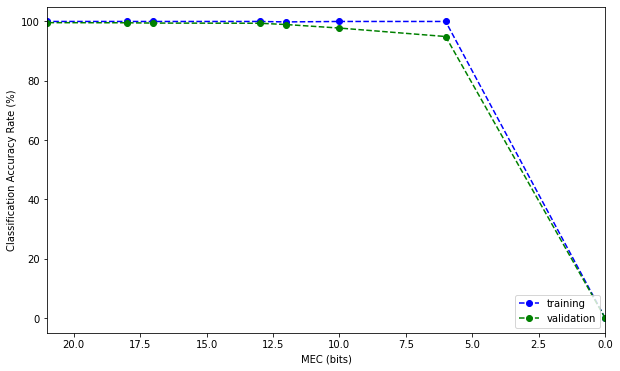

In [ ]:
import matplotlib.pyplot as plt
train_acc = {
21: 100.00,
18: 100.00, 
17: 100.00, 
13: 100.00, 
12: 99.85, 
10: 100.00, 
6: 100.00,
0: 0}

val_acc = {
21: 99.60,
18: 99.56, 
17: 99.46, 
13: 99.40, 
12: 98.96, 
10: 97.78, 
6: 94.92,
0: 0}


train_acc = sorted(train_acc.items()) # sorted by key, return a list of tuples
val_acc = sorted(val_acc.items()) # sorted by key, return a list of tuples

# Add title and axis names

# creating an x sequence
x = np.linspace(0, 21)

plt.clf()
x1, y1 = zip(*train_acc) # unpack a list of pairs into two tuples
x2, y2 = zip(*val_acc) # unpack a list of pairs into two tuples
# plt.ylim(0, 100)
plt.plot(x1, y1, '--bo', label="training")
plt.plot(x2, y2, '--go', label="validation")
plt.legend(loc='lower right')
plt.title('')
plt.xlabel('MEC (bits)')
plt.ylabel('Classification Accuracy Rate (%)')
plt.rcParams["figure.figsize"] = (10,6)
plt.xlim(max(x), min(x))
plt.show()

### Train with input = raw RGB data

In [ ]:
raw_data_flattened = [x.flatten() for x in DATA_DF.image]

In [ ]:
pd.DataFrame(raw_data_flattened) 

In [ ]:


# Sample 50%
TRAIN_DF_50 = DATA_DF[:int(len(DATA_DF)*.5)]
TRAIN_DF_50[['image_flattened', 'label']].to_csv('/content/drive/MyDrive/CS29482/data/rgb_50.csv', index=False)

# Sample 100%
TRAIN_DF_100 = DATA_DF[:int(len(DATA_DF)*1)]
TRAIN_DF_100[['image_flattened', 'label']].to_csv('/content/drive/MyDrive/CS29482/data/rgb_100.csv', index=False)

In [ ]:
!brainome '/content/drive/MyDrive/CS29482/data/rgb_50.csv' -v -y -target label -o rgb_10class_measurement_script.py


Brainome Table Compiler v1.700-108-prod
Copyright (c) 2019-2021 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2022-12-12   363 days left
Maximum File Size:           100 MB
Maximum Instances:           20000
Maximum Attributes:          100
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    btc /content/drive/MyDrive/CS29482/data/rgb_50.csv -v -y -target label -o rgb_10class_measurement_script.py

Start Time:                 12/14/2021, 03:32 UTC

Cleaning...-done. < 1s
Splitting into training and validation...-/|\-/done. 1s
Pre-training measurements...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\done. 6s


Pre-training Measurements
Data:
    Input:                      /content/drive/MyDrive/CS29482/data/rgb_50.csv
    Target Column:              label
    Number of i

In [ ]:
!brainome '/content/drive/MyDrive/CS29482/data/rgb_100.csv' -v -y -target label -o rgb_10class_measurement_script.py


Brainome Table Compiler v1.700-108-prod
Copyright (c) 2019-2021 Brainome, Inc. All Rights Reserved.
Licensed to:                 Demo User  (Evaluation)
Expiration Date:             2022-12-12   363 days left
Maximum File Size:           100 MB
Maximum Instances:           20000
Maximum Attributes:          100
Maximum Classes:             unlimited
Connected to:                daimensions.brainome.ai  (local execution)

Command:
    btc /content/drive/MyDrive/CS29482/data/rgb_100.csv -v -y -target label -o rgb_10class_measurement_script.py

Start Time:                 12/14/2021, 03:33 UTC

Cleaning...-done. < 1s
Splitting into training and validation...-/|\-/|\-/done. 1s
Pre-training measurements...-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/|\-/done. 11s


Pre-training Measurements
Data:
    Input:                      /content/drive

# Train for Memorization

In [56]:
hidden_layer = 15
memorization_mec = 2048 * hidden_layer + hidden_layer + min(hidden_layer, (hidden_layer + 1) * 10)
memorization_mec

30750

In [57]:
model.network.fc = nn.Sequential(
                              nn.Linear(2048, 15),
                              nn.ReLU(),
                              nn.Linear(15, 10),
                              nn.LogSoftmax(dim=1)
                                )

model

LULC_Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [58]:
device = get_device()
## Loading data to devide
# train_dl = DeviceDataLoader(train_dl, device)
# valid_dl = DeviceDataLoader(valid_dl, device)
## Loading model to device
model = to_device(model, device)

True


In [59]:
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.9227, learning_rate: 0.0001, train_loss: 0.3412, val_loss: 0.1304, val_acc: 0.9625


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9681, learning_rate: 0.0001, train_loss: 0.1176, val_loss: 0.0955, val_acc: 0.9724


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9751, learning_rate: 0.0001, train_loss: 0.0871, val_loss: 0.1024, val_acc: 0.9735


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9776, learning_rate: 0.0001, train_loss: 0.0764, val_loss: 0.0833, val_acc: 0.9789


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9814, learning_rate: 0.0001, train_loss: 0.0634, val_loss: 0.0943, val_acc: 0.9727


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9822, learning_rate: 0.0001, train_loss: 0.0599, val_loss: 0.1200, val_acc: 0.9669


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9816, learning_rate: 0.0001, train_loss: 0.0613, val_loss: 0.1040, val_acc: 0.9760


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9843, learning_rate: 0.0000, train_loss: 0.0562, val_loss: 0.0878, val_acc: 0.9800


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9850, learning_rate: 0.0000, train_loss: 0.0532, val_loss: 0.0879, val_acc: 0.9782


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9831, learning_rate: 0.0000, train_loss: 0.0581, val_loss: 0.0865, val_acc: 0.9771


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9837, learning_rate: 0.0000, train_loss: 0.0561, val_loss: 0.0925, val_acc: 0.9757


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9847, learning_rate: 0.0000, train_loss: 0.0540, val_loss: 0.0868, val_acc: 0.9778
VAL LOSS MIN 0.08330641686916351
VAL ACC MAX 0.9800145626068115


In [60]:
evaluate(model, test_dl)

{'val_acc': 0.9763808250427246, 'val_loss': 0.08262214064598083}

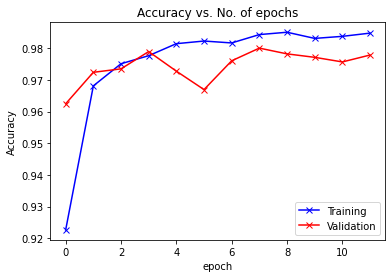

In [61]:
plot_accuracy(history)

In [62]:
hidden_layer = 14
memorization_mec = 2048 * hidden_layer + hidden_layer + min(hidden_layer, (hidden_layer + 1) * 10)
memorization_mec

28700

In [29]:
model.network.fc = nn.Sequential(
                              nn.Linear(2048, 14),
                              nn.ReLU(),
                              nn.Linear(14, 10),
                              nn.LogSoftmax(dim=1)
                                )

In [63]:
device = get_device()
## Loading data to devide
# train_dl = DeviceDataLoader(train_dl, device)
# valid_dl = DeviceDataLoader(valid_dl, device)
## Loading model to device
model = to_device(model, device)

True


In [64]:
## Freezing except last layer
model.freeze()
## Training
epochs = 12
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.9811, learning_rate: 0.0001, train_loss: 0.0634, val_loss: 0.1282, val_acc: 0.9618


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9828, learning_rate: 0.0001, train_loss: 0.0581, val_loss: 0.0911, val_acc: 0.9720


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9835, learning_rate: 0.0001, train_loss: 0.0536, val_loss: 0.1220, val_acc: 0.9640


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9853, learning_rate: 0.0001, train_loss: 0.0497, val_loss: 0.0830, val_acc: 0.9757


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9883, learning_rate: 0.0001, train_loss: 0.0422, val_loss: 0.1065, val_acc: 0.9661


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9818, learning_rate: 0.0001, train_loss: 0.0608, val_loss: 0.0782, val_acc: 0.9735


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9909, learning_rate: 0.0001, train_loss: 0.0332, val_loss: 0.0924, val_acc: 0.9749


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9891, learning_rate: 0.0001, train_loss: 0.0391, val_loss: 0.0980, val_acc: 0.9655


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9886, learning_rate: 0.0001, train_loss: 0.0417, val_loss: 0.0792, val_acc: 0.9735


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9946, learning_rate: 0.0000, train_loss: 0.0221, val_loss: 0.0710, val_acc: 0.9782


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9955, learning_rate: 0.0000, train_loss: 0.0194, val_loss: 0.0639, val_acc: 0.9811


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9953, learning_rate: 0.0000, train_loss: 0.0212, val_loss: 0.0704, val_acc: 0.9775
VAL LOSS MIN 0.06386418640613556
VAL ACC MAX 0.9811046719551086


In [65]:
evaluate(model, test_dl)

{'val_acc': 0.9802567958831787, 'val_loss': 0.06544142216444016}

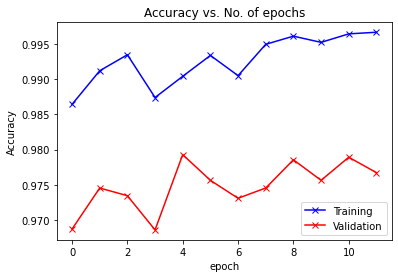

In [68]:
plot_accuracy(history)

In [66]:
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.9864, learning_rate: 0.0001, train_loss: 0.0446, val_loss: 0.1045, val_acc: 0.9688


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9912, learning_rate: 0.0001, train_loss: 0.0336, val_loss: 0.0917, val_acc: 0.9746


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9934, learning_rate: 0.0001, train_loss: 0.0253, val_loss: 0.0827, val_acc: 0.9735


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9874, learning_rate: 0.0001, train_loss: 0.0427, val_loss: 0.1120, val_acc: 0.9686


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9904, learning_rate: 0.0001, train_loss: 0.0352, val_loss: 0.0719, val_acc: 0.9793


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9933, learning_rate: 0.0001, train_loss: 0.0268, val_loss: 0.0963, val_acc: 0.9757


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9905, learning_rate: 0.0001, train_loss: 0.0335, val_loss: 0.0803, val_acc: 0.9731


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9949, learning_rate: 0.0001, train_loss: 0.0218, val_loss: 0.0982, val_acc: 0.9746


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9961, learning_rate: 0.0000, train_loss: 0.0177, val_loss: 0.0778, val_acc: 0.9786


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9952, learning_rate: 0.0000, train_loss: 0.0200, val_loss: 0.0896, val_acc: 0.9757


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9964, learning_rate: 0.0000, train_loss: 0.0179, val_loss: 0.0794, val_acc: 0.9789


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9966, learning_rate: 0.0000, train_loss: 0.0181, val_loss: 0.0837, val_acc: 0.9767
VAL LOSS MIN 0.07190179824829102
VAL ACC MAX 0.9792878031730652


In [67]:
hidden_layer = 13
memorization_mec = 2048 * hidden_layer + hidden_layer + min(hidden_layer, (hidden_layer + 1) * 10)
memorization_mec

26650

In [69]:
model.network.fc = nn.Sequential(
                              nn.Linear(2048, 13),
                              nn.ReLU(),
                              nn.Linear(13, 10),
                              nn.LogSoftmax(dim=1)
                                )

model

LULC_Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [70]:
model = to_device(model, device)
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.8820, learning_rate: 0.0001, train_loss: 0.6234, val_loss: 0.1709, val_acc: 0.9717


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9829, learning_rate: 0.0001, train_loss: 0.1057, val_loss: 0.1251, val_acc: 0.9651


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9871, learning_rate: 0.0001, train_loss: 0.0621, val_loss: 0.1038, val_acc: 0.9749


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9893, learning_rate: 0.0001, train_loss: 0.0485, val_loss: 0.1105, val_acc: 0.9684


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9908, learning_rate: 0.0001, train_loss: 0.0426, val_loss: 0.0850, val_acc: 0.9775


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9908, learning_rate: 0.0001, train_loss: 0.0396, val_loss: 0.0926, val_acc: 0.9735


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9927, learning_rate: 0.0001, train_loss: 0.0296, val_loss: 0.0857, val_acc: 0.9767


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9911, learning_rate: 0.0001, train_loss: 0.0351, val_loss: 0.1135, val_acc: 0.9684


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9932, learning_rate: 0.0000, train_loss: 0.0285, val_loss: 0.0728, val_acc: 0.9786


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9934, learning_rate: 0.0000, train_loss: 0.0273, val_loss: 0.0768, val_acc: 0.9760


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9934, learning_rate: 0.0000, train_loss: 0.0279, val_loss: 0.0753, val_acc: 0.9778


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9935, learning_rate: 0.0000, train_loss: 0.0273, val_loss: 0.0770, val_acc: 0.9775
VAL LOSS MIN 0.07278866320848465
VAL ACC MAX 0.9785610437393188


In [71]:
evaluate(model, test_dl)

{'val_acc': 0.976259708404541, 'val_loss': 0.0846903845667839}

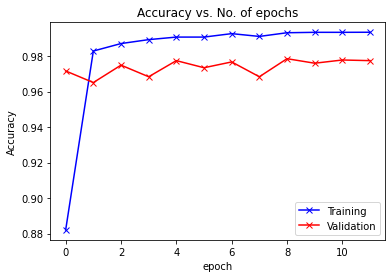

In [72]:
plot_accuracy(history)

In [73]:
hidden_layer = 12
memorization_mec = 2048 * hidden_layer + hidden_layer + min(hidden_layer, (hidden_layer + 1) * 10)
memorization_mec

24600

In [74]:
model.network.fc = nn.Sequential(
                              nn.Linear(2048, 12),
                              nn.ReLU(),
                              nn.Linear(12, 10),
                              nn.LogSoftmax(dim=1)
                                )

model

LULC_Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [75]:
model = to_device(model, device)
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.9434, learning_rate: 0.0001, train_loss: 0.4717, val_loss: 0.1815, val_acc: 0.9568


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9859, learning_rate: 0.0001, train_loss: 0.0821, val_loss: 0.2113, val_acc: 0.9502


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9887, learning_rate: 0.0001, train_loss: 0.0529, val_loss: 0.1314, val_acc: 0.9650


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9902, learning_rate: 0.0001, train_loss: 0.0446, val_loss: 0.1003, val_acc: 0.9709


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9930, learning_rate: 0.0001, train_loss: 0.0332, val_loss: 0.1183, val_acc: 0.9673


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9915, learning_rate: 0.0001, train_loss: 0.0356, val_loss: 0.0788, val_acc: 0.9793


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9921, learning_rate: 0.0001, train_loss: 0.0336, val_loss: 0.0793, val_acc: 0.9786


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9909, learning_rate: 0.0001, train_loss: 0.0350, val_loss: 0.1189, val_acc: 0.9680


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9942, learning_rate: 0.0001, train_loss: 0.0259, val_loss: 0.0898, val_acc: 0.9706


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9934, learning_rate: 0.0000, train_loss: 0.0274, val_loss: 0.1040, val_acc: 0.9706


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9935, learning_rate: 0.0000, train_loss: 0.0273, val_loss: 0.0985, val_acc: 0.9706


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9929, learning_rate: 0.0000, train_loss: 0.0314, val_loss: 0.0954, val_acc: 0.9720
VAL LOSS MIN 0.0788290947675705
VAL ACC MAX 0.9792878031730652


In [76]:
evaluate(model, test_dl)

{'val_acc': 0.9748062491416931, 'val_loss': 0.08615100383758545}

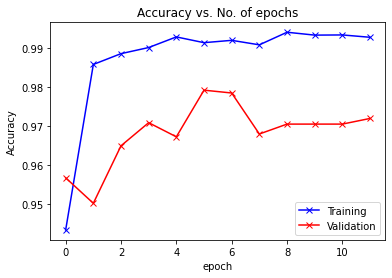

In [77]:
plot_accuracy(history)

In [78]:
hidden_layer = 10
memorization_mec = 2048 * hidden_layer + hidden_layer + min(hidden_layer, (hidden_layer + 1) * 10)
memorization_mec

20500

In [79]:
model.network.fc = nn.Sequential(
                              nn.Linear(2048, 10),
                              nn.ReLU(),
                              nn.Linear(10, 10),
                              nn.LogSoftmax(dim=1)
                                )

model

LULC_Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [80]:
model = to_device(model, device)
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.8625, learning_rate: 0.0001, train_loss: 0.5560, val_loss: 0.2580, val_acc: 0.9611


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9868, learning_rate: 0.0001, train_loss: 0.1076, val_loss: 0.1932, val_acc: 0.9593


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9913, learning_rate: 0.0001, train_loss: 0.0521, val_loss: 0.1964, val_acc: 0.9568


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9921, learning_rate: 0.0001, train_loss: 0.0423, val_loss: 0.0790, val_acc: 0.9818


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9939, learning_rate: 0.0001, train_loss: 0.0307, val_loss: 0.1267, val_acc: 0.9720


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9957, learning_rate: 0.0001, train_loss: 0.0227, val_loss: 0.0881, val_acc: 0.9818


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9948, learning_rate: 0.0001, train_loss: 0.0273, val_loss: 0.1214, val_acc: 0.9702


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9932, learning_rate: 0.0000, train_loss: 0.0313, val_loss: 0.0966, val_acc: 0.9760


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9927, learning_rate: 0.0000, train_loss: 0.0326, val_loss: 0.1021, val_acc: 0.9738


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9928, learning_rate: 0.0000, train_loss: 0.0327, val_loss: 0.0986, val_acc: 0.9757


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9929, learning_rate: 0.0000, train_loss: 0.0336, val_loss: 0.1052, val_acc: 0.9731


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9926, learning_rate: 0.0000, train_loss: 0.0326, val_loss: 0.1090, val_acc: 0.9720
VAL LOSS MIN 0.07900863140821457
VAL ACC MAX 0.9818313717842102


In [81]:
evaluate(model, test_dl)

{'val_acc': 0.973716139793396, 'val_loss': 0.09702859818935394}

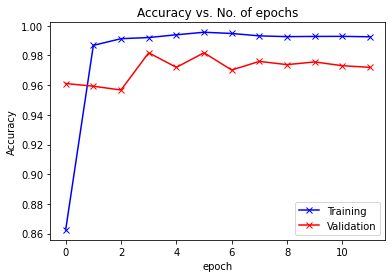

In [82]:
plot_accuracy(history)

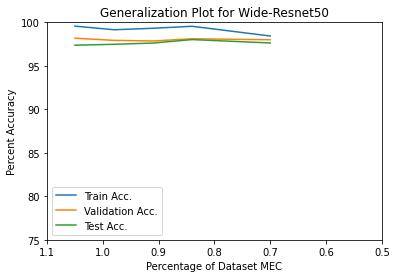

In [97]:
train_accs = [98.43, 99.55, 99.32, 99.15, 99.57]
validation_accs = [98.0, 98.11, 97.86, 97.93, 98.18]
test_accs = [ 97.63, 98.02, 97.62, 97.48, 97.37]
mec_pct = np.flip(np.array([30750, 28700, 26650, 24600, 20500])/29283.31)

plt.plot(mec_pct, train_accs, mec_pct, validation_accs, mec_pct, test_accs)
plt.legend(["Train Acc.", "Validation Acc.", "Test Acc."])
plt.xlabel('Percentage of Dataset MEC');
plt.ylabel('Percent Accuracy');
plt.ylim([75,100])
plt.xlim([1.1, 0.5])
plt.title('Generalization Plot for Wide-Resnet50');